
# Load data

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from datetime import datetime
import time

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fileName = '/content/drive/My Drive/Colab Notebooks/ML/data/GDAX.BTC-USD_160101_200528_h.csv'
data = pd.read_csv(fileName, sep=',')
data.rename(columns={'<DATE>':'date', '<TIME>':'time', '<OPEN>':'open',\
      '<HIGH>':'high', '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'vol'}, inplace=True)
data

,date,time,open,high,low,close,vol
0,10116,10000,431.96,434.00,431.75,432.88,214
1,10116,20000,432.83,433.13,430.25,431.64,667
2,10116,30000,431.49,432.01,429.00,430.35,322
3,10116,40000,430.35,431.82,430.35,430.61,160
4,10116,50000,430.59,430.98,430.00,430.78,89
...,...,...,...,...,...,...,...
38081,280520,210000,9450.14,9477.13,9448.83,9470.01,490
38082,280520,220000,9470.01,9482.16,9430.01,9430.01,513
38083,280520,230000,9430.01,9483.00,9408.27,9453.99,488
38084,290520,0,9455.46,9462.68,9420.45,9446.57,360


# Data preprocessing

In [ ]:
def BatchGen(data, learnBatch, secLen, predLen, DType=torch.float64,\
             secondDim=None, targedIndex=0):
  batchReserved = secLen + predLen + learnBatch - 1
  batchCount = data.size()[1] // batchReserved
  if secondDim == None:
    X = torch.empty((batchCount, learnBatch, 1, secLen), dtype=DType)
    Y = torch.empty((batchCount, learnBatch, 1, predLen), dtype=DType)
  else:
    X = torch.empty((batchCount, learnBatch, 1, secondDim, secLen), dtype=DType)
    Y = torch.empty((batchCount, learnBatch, 1, 1, predLen), dtype=DType)

  for batch in range(batchCount):
    for dot in range(learnBatch):
      xBegin = batch * batchReserved + dot
      xEnd = xBegin + secLen

      Y[batch][dot][0] = data[targedIndex][xEnd:xEnd + predLen]
      if secondDim == None:
        X[batch][dot][0] = data[targedIndex][xBegin:xEnd]
      else:
        X[batch][dot] = data[:, xBegin:xEnd]

  return X, Y

def TestSample(data, secLen, secondDim=None, targedIndex=0):
  testLen = len(data[targedIndex]) - secLen
  if secondDim == None:
    result = torch.tensor([data[targedIndex][index:index + secLen].tolist()\
        for index in range(testLen)], dtype=torch.float64, requires_grad=False)
    return result.view((testLen, 1, secLen))
  else:
    result = torch.tensor([data[:, index:index + secLen].tolist()\
        for index in range(testLen)], dtype=torch.float64, requires_grad=False)
    return result.view((testLen, 1, secondDim, secLen))

def GetNormalizeConstants(data):
  normSub = np.min(data)
  normDiv = np.max(data - normSub)
  return normSub, normDiv

def MAPE(y, pred):
  return np.sum(np.abs(pred - y) / y) / len(y) * 100.0

from 150818 to 290520


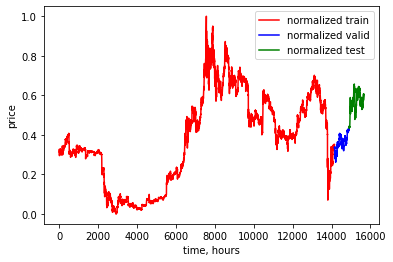

In [ ]:
ReservedSecLen = 150
TrainLen = 14000 # 8000 # 6000
TestLen = 600 + ReservedSecLen
ValidLen = 600 + ReservedSecLen

TargetAttribute = 'low'
DataAttributes = {'high':0, 'low':1, 'close':2, 'vol':3}
TargetIndex = DataAttributes[TargetAttribute]

TrainBegin = len(data) - ReservedSecLen - TrainLen - TestLen - ValidLen
TestBegin = len(data) - TestLen - ValidLen
ValidBegin = len(data) - ValidLen

train = torch.transpose(torch.Tensor(data[['high', 'low', 'close', 'vol']]\
                            [TrainBegin:TestBegin].to_numpy()).double(), 0, 1)
test = torch.transpose(torch.Tensor(data[['high', 'low', 'close', 'vol']]\
                            [TestBegin:ValidBegin].to_numpy()).double(), 0, 1)
valid = torch.transpose(torch.Tensor(data[['high', 'low', 'close', 'vol']]\
                            [ValidBegin:].to_numpy()).double(), 0, 1)

attributes = 4
NormSub, NormDiv = [x for x in range(attributes)], [x for x in range(attributes)]
for i in range(attributes):
  NormSub[i], NormDiv[i] = GetNormalizeConstants(data[TargetAttribute][TrainBegin:])
  train[i] = (train[i] - NormSub[i]) / NormDiv[i]
  test[i] = (test[i] - NormSub[i]) / NormDiv[i]
  valid[i] = (valid[i] - NormSub[i]) / NormDiv[i]

fig, ax = plt.subplots()
ax.plot([x for x in range(TrainLen + ReservedSecLen)], train[TargetIndex],
         label='normalized train', color='r')
ax.plot([x + TrainLen + ReservedSecLen for x in range(TestLen)],\
         test[TargetIndex], label='normalized valid', color='b')
ax.plot([x + TrainLen + ReservedSecLen + TestLen for x in range(ValidLen)],\
         valid[TargetIndex], label='normalized test', color='g')

ax.set_ylabel('price')
ax.set_xlabel('time, hours')
ax.legend(loc='best')
print('from ' + str(data['date'][TrainBegin]) + ' to ' + str(data['date'][len(data)-1]))

# Base CNN

In [ ]:
class BaseCNN(nn.Module):
  def __init__(self, SecLen=100, PredLen=1):
    super(BaseCNN, self).__init__()
    self.secLen = SecLen
    self.predLen = PredLen

  def _WeightsToGPU_(self):
    self.double()
    self.cuda()
    self.devCuda = torch.device('cuda')
  
  def _CreateOptimizer_(self, LR=0.03, m=0.65):
    self.loss_func = nn.L1Loss()
    self.optimizer = torch.optim.SGD(self.parameters(), lr=LR, momentum=m)

  def forward(self, x):
    if x.device.type == 'cpu':
      return self.net(x.cuda(device=self.devCuda)).cpu()
    else:
      return self.net(x)

  def fit(self, X, Y, epochs = 1):
    XGPU = X.cuda(device=self.devCuda)
    YGPU = Y.cuda(device=self.devCuda)

    losses = torch.empty(epochs, dtype=torch.float32,
                        requires_grad=False, device=self.devCuda)
    
    for epoch in range(epochs):
      epochLoss = 0.0
      for batch in range(X.size()[0]):
        prediction = self.forward(XGPU[batch])
        loss = self.loss_func(prediction, YGPU[batch])
        epochLoss += loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

      losses[epoch] = epochLoss

    return losses.detach().cpu()
      

In [ ]:
PlotColors = ['b', 'g', 'r', 'cornflowerblue', 'c', 'm', 'y']

def PlotPredictions(y, pred, atr, MAPE):
  fig, ax = plt.subplots()
  fig.set_figwidth(12)
  fig.set_figheight(6)

  for i in range(atr['PredLen']):
    ax.plot(pred[i], label='прогноз ' + str(i + 1), color=PlotColors[i])
  ax.plot(y, label='Y', color='orange')

  ax.set_ylabel('цена, USD')
  ax.set_xlabel('время, часы')
  ax.legend(loc='best')

  print('MAPE ' + str(MAPE))
  print({'SecLen':atr['SecLen'], ' PredLen':atr['PredLen'], 'Epochs':atr['Epochs'],
         'LR':atr['LR'], 'M':atr['M'], 'target':TargetAttribute})

def PredMAPE(y, pred, predLen):
  return [MAPE(y, pred[i]) for i in range(predLen)]

# Small CNN

In [ ]:
class SmallCNN(BaseCNN):
  def __init__(self, LR=0.03, m=0.65, SecLen=100, PredLen=1):
    super(SmallCNN, self).__init__(SecLen=SecLen, PredLen=PredLen)
    self.net = nn.Sequential(
        nn.Sequential(nn.Conv1d(1, 1, 75), nn.Linear(76, 40), nn.LeakyReLU()),
        nn.Sequential(nn.Conv1d(1, 1, 21), nn.Linear(20, 10), nn.LeakyReLU()),
        nn.Sequential(nn.Conv1d(1, 1, 5), nn.Linear(6, PredLen)))
    
    self._WeightsToGPU_()
    self._CreateOptimizer_(LR=LR, m=m)

0:00:52.127786


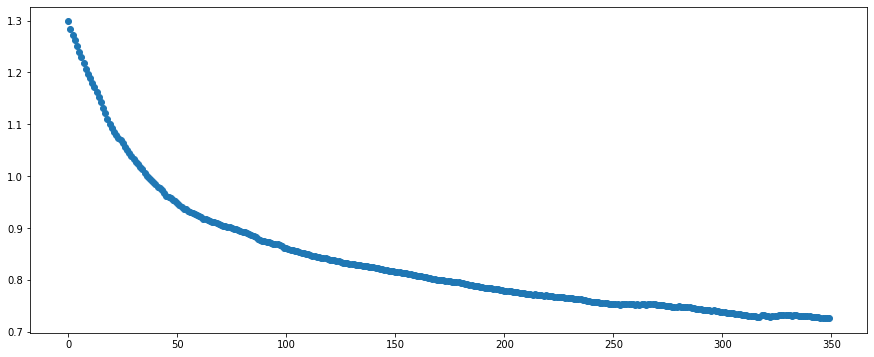

In [ ]:
small = {'LearnBatch':100, 'SecLen':150, 'PredLen':4,
'Epochs':400, 'LR':0.00115, 'M':0.65}

small['trainX'], small['trainY'] = BatchGen(train, small['LearnBatch'],\
                                        small['SecLen'], small['PredLen'])
small['testX'] = TestSample(test, small['SecLen'])
small['validX'] = TestSample(valid, small['SecLen'])

small['cnn'] = SmallCNN(LR=small['LR'], m=small['M'],\
                        SecLen=small['SecLen'], PredLen=small['PredLen'])
start_time = datetime.now()
small['losses'] = small['cnn'].fit(small['trainX'], small['trainY'],\
                                   epochs=small['Epochs'])

print(datetime.now() - start_time)
plt.figure(figsize=(15, 6))
plt.scatter(np.array([float(i) for i in range(len(small['losses'][50:]))]),\
            small['losses'][50:].numpy())

MAPE [3.935935835796273, 3.6876855019601438, 3.3970275955628364, 3.85886224764991]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 400, 'LR': 0.00115, 'M': 0.65, 'target': 'low'}


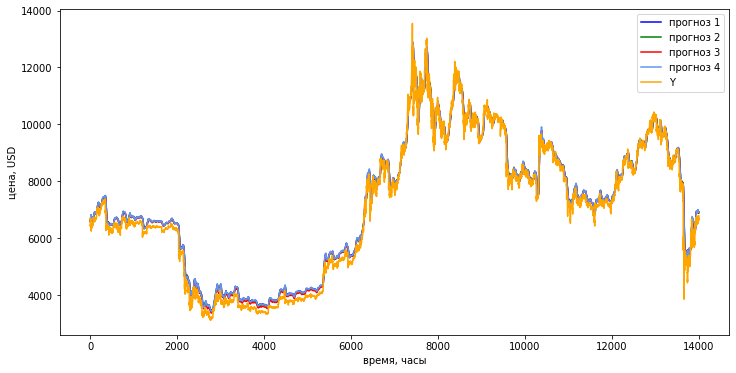

In [ ]:
trainPred = torch.transpose(small['cnn'](TestSample(train, small['SecLen']))\
      .view((-1, small['PredLen'])), 0, 1).detach().numpy()\
      * NormDiv[TargetIndex] + NormSub[TargetIndex]
trainY = data[TargetAttribute][TrainBegin + small['SecLen']:TestBegin].to_numpy()
small['MAPETrain'] = PredMAPE(trainY, trainPred, small['PredLen'])

PlotPredictions(trainY, trainPred, small, small['MAPETrain'])

MAPE [2.9843526207180964, 2.824000812527711, 2.801247444846976, 3.0278829577374227]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 400, 'LR': 0.00115, 'M': 0.65, 'target': 'low'}


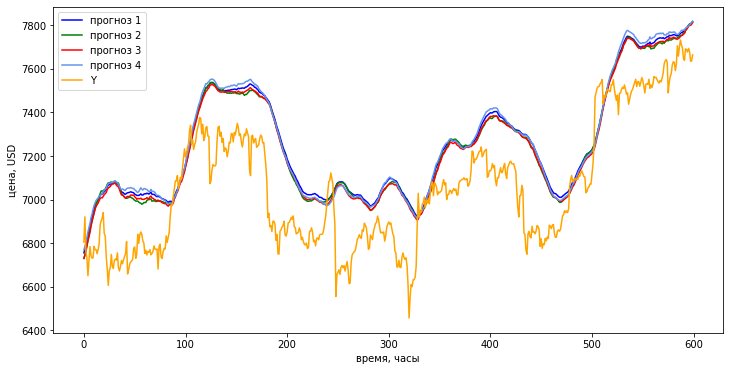

In [ ]:
testPred = torch.transpose(small['cnn'](TestSample(test, small['SecLen']))\
      .view((-1, small['PredLen'])), 0, 1).detach().numpy()\
      * NormDiv[TargetIndex] + NormSub[TargetIndex]
testY = data[TargetAttribute][TestBegin + small['SecLen']:ValidBegin].to_numpy()
small['MAPETest'] = PredMAPE(testY, testPred, small['PredLen'])

PlotPredictions(testY, testPred, small, small['MAPETest'])

# Small CNN 2d

In [ ]:
class SmallCNN2d(BaseCNN):
  def __init__(self, LR=0.03, m=0.65, SecLen=100, PredLen=1):
    super(SmallCNN2d, self).__init__(SecLen=SecLen, PredLen=PredLen)
    self.net = nn.Sequential(
        nn.Sequential(nn.Conv2d(1, 1, (3, 75)), nn.Linear(76, 40), nn.LeakyReLU()),
        nn.Sequential(nn.Conv2d(1, 1, (2, 21)), nn.Linear(20, 10)),
        nn.Sequential(nn.Conv2d(1, 1, (1, 5)), nn.Linear(6, PredLen)))
    
    self._WeightsToGPU_()
    self._CreateOptimizer_(LR=LR, m=m)

0:03:57.630719


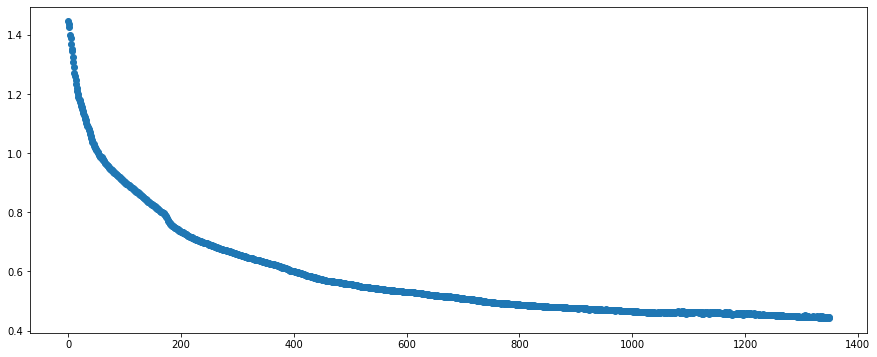

In [ ]:
small2d = {'LearnBatch':100, 'SecLen':150, 'PredLen':4,
'Epochs':1400, 'LR':0.00115, 'M':0.65, 'SecondDim':4}

trainX2d, trainY2d = BatchGen(train, small2d['LearnBatch'], small2d['SecLen'],
                              small2d['PredLen'], secondDim=small2d['SecondDim'])
testX2d = TestSample(test, small2d['SecLen'], secondDim=small2d['SecondDim'])
validX2d = TestSample(valid, small2d['SecLen'], secondDim=small2d['SecondDim'])

small2d['cnn'] = SmallCNN2d(LR=small2d['LR'], m=small2d['M'], SecLen=small2d['SecLen'],\
                   PredLen=small2d['PredLen'])
start_time = datetime.now()
small2d['losses'] = small2d['cnn'].fit(trainX2d, trainY2d, epochs=small2d['Epochs'])

print(datetime.now() - start_time)
plt.figure(figsize=(15, 6))
plt.scatter(np.array([float(i) for i in range(len(small2d['losses'][50:]))]),\
            small2d['losses'][50:].numpy())

MAPE [1.2800874292501823, 1.3113417243105667, 1.2194473121934197, 1.357039316320009]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 1400, 'LR': 0.00115, 'M': 0.65, 'target': 'low'}


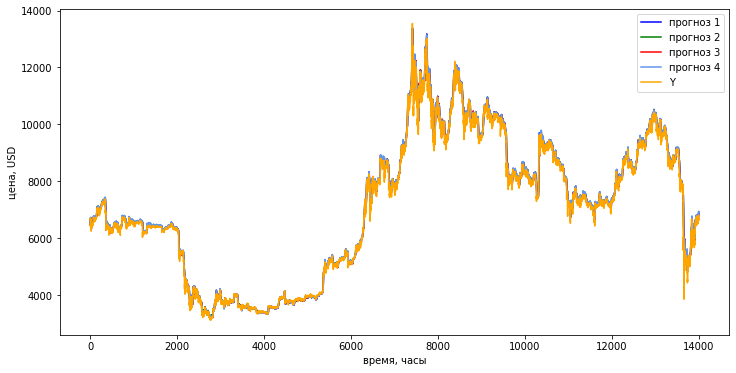

In [ ]:
trainPred = torch.transpose(small2d['cnn'](TestSample(train, small2d['SecLen'],\
      secondDim=small2d['SecondDim'])).view((-1, small2d['PredLen'])), 0, 1)\
      .detach().numpy() * NormDiv[TargetIndex] + NormSub[TargetIndex]
trainY = data[TargetAttribute][TrainBegin + small2d['SecLen']:TestBegin].to_numpy()
small2d['MAPETrain'] = PredMAPE(trainY, trainPred, small2d['PredLen'])

PlotPredictions(trainY, trainPred, small2d, small2d['MAPETrain'])

MAPE [1.3811466942105415, 1.484686322925512, 1.222298579444883, 1.5675097263875943]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 1400, 'LR': 0.00115, 'M': 0.65, 'target': 'low'}


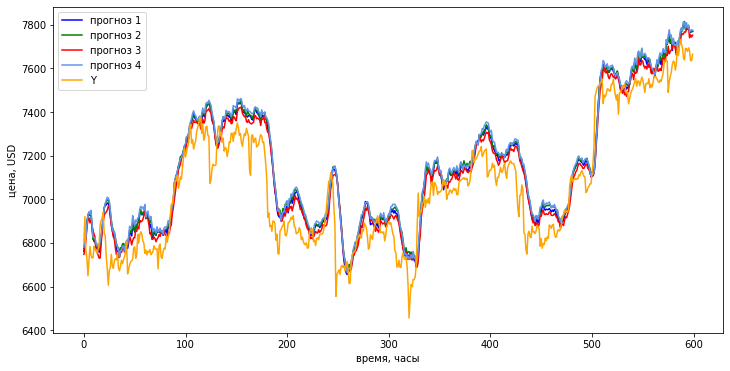

In [ ]:
testPred = torch.transpose(small2d['cnn'](TestSample(test, small2d['SecLen'],\
      secondDim=small2d['SecondDim'])).view((-1, small2d['PredLen'])), 0, 1)\
      .detach().numpy() * NormDiv[TargetIndex] + NormSub[TargetIndex]
testY = data[TargetAttribute][TestBegin + small2d['SecLen']:ValidBegin].to_numpy()
small2d['MAPETest'] = PredMAPE(testY, testPred, small2d['PredLen'])

PlotPredictions(testY, testPred, small2d, small2d['MAPETest'])

# Medium CNN

In [ ]:
class MediumCNN(BaseCNN):
  def __init__(self, LR=0.03, m=0.65, SecLen=100, PredLen=1):
    super(MediumCNN, self).__init__(SecLen=SecLen, PredLen=PredLen)
    self.net = nn.Sequential(
      nn.Sequential(nn.Conv1d(1, 1, 41), nn.Linear(110, 102), nn.MaxPool1d(3)),
      nn.Sequential(nn.Conv1d(1, 1, 11), nn.Linear(24, 20), nn.LeakyReLU()),
      nn.Sequential(nn.Conv1d(1, 1, 7), nn.Linear(14, 10), nn.LeakyReLU()),
      nn.Sequential(nn.Conv1d(1, 1, 5), nn.Linear(6, PredLen)))
    
    self._WeightsToGPU_()
    self._CreateOptimizer_(LR=LR, m=m)

0:03:57.354476


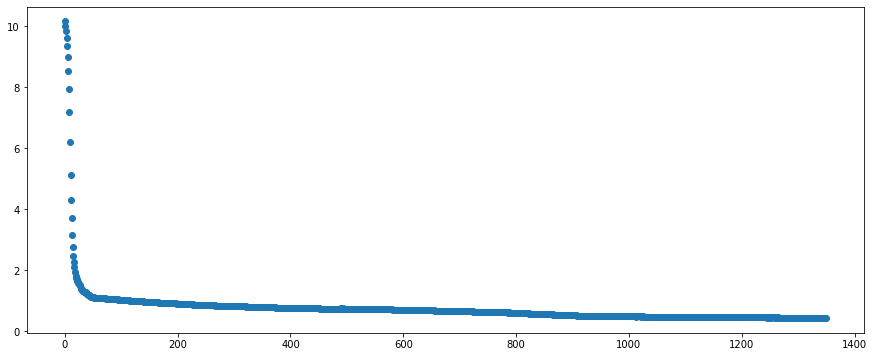

In [ ]:
medium = {'LearnBatch':100, 'SecLen':150, 'PredLen':4,
'Epochs':1400, 'LR':0.00195, 'M':0.65}

trainX, trainY = BatchGen(train, medium['LearnBatch'],\
                          medium['SecLen'], medium['PredLen'])
testX = TestSample(test, medium['SecLen'])
validX = TestSample(valid, medium['SecLen'])

medium['cnn'] = MediumCNN(LR=medium['LR'], m=medium['M'],\
                          SecLen=medium['SecLen'], PredLen=medium['PredLen'])
start_time = datetime.now()
medium['losses'] = medium['cnn'].fit(trainX, trainY, epochs=medium['Epochs'])

print(datetime.now() - start_time)
plt.figure(figsize=(15, 6))
plt.scatter(np.array([float(i) for i in range(len(medium['losses'][50:]))]),\
            medium['losses'][50:].numpy())

MAPE [1.1852419790062636, 1.2044456254284657, 1.2725950181040564, 1.2558790652133207]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 1400, 'LR': 0.00195, 'M': 0.65, 'target': 'low'}


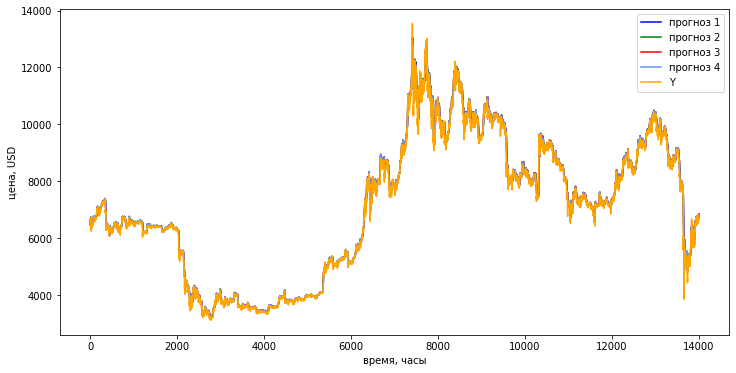

In [ ]:
trainPred = torch.transpose(medium['cnn'](TestSample(train, medium['SecLen']))\
      .view((-1, medium['PredLen'])), 0, 1).detach().numpy()\
      * NormDiv[TargetIndex] + NormSub[TargetIndex]
trainY = data[TargetAttribute][TrainBegin + medium['SecLen']:TestBegin].to_numpy()
medium['MAPETrain'] = PredMAPE(trainY, trainPred, medium['PredLen'])

PlotPredictions(trainY, trainPred, medium, medium['MAPETrain'])

MAPE [1.1895361746208035, 1.1824006660784698, 1.2436895612635506, 1.2270161122672163]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 1400, 'LR': 0.00195, 'M': 0.65, 'target': 'low'}


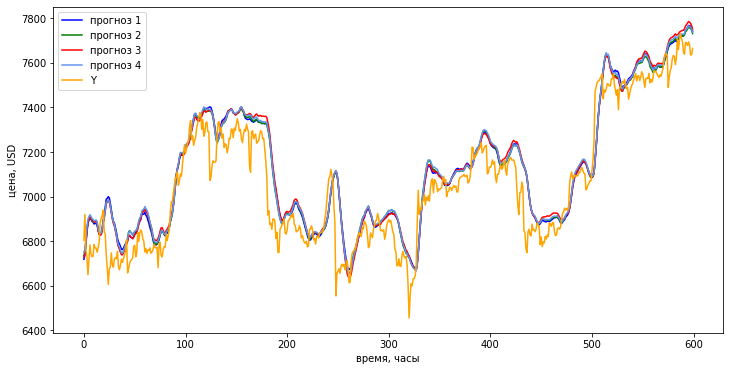

In [ ]:
testPred = torch.transpose(medium['cnn'](TestSample(test, medium['SecLen']))\
      .view((-1, medium['PredLen'])), 0, 1).detach().numpy()\
      * NormDiv[TargetIndex] + NormSub[TargetIndex]
testY = data[TargetAttribute][TestBegin + medium['SecLen']:ValidBegin].to_numpy()
medium['MAPETest'] = PredMAPE(testY, testPred, medium['PredLen'])

PlotPredictions(testY, testPred, medium, medium['MAPETest'])

# Medium CNN 2d

In [ ]:
class MediumCNN2dOld(BaseCNN):
  def __init__(self, LR=0.03, m=0.65, SecLen=100, PredLen=1):
    super(MediumCNN2dOld, self).__init__(SecLen=SecLen, PredLen=PredLen)
    self.net = nn.Sequential(
      nn.Sequential(nn.MaxPool2d((1, 3)), nn.Linear(50, 50), nn.LeakyReLU()),
      nn.Sequential(nn.Conv2d(1, 1, (2, 15)), nn.Linear(36, 33), nn.LeakyReLU()), 
      nn.Sequential(nn.Conv2d(1, 1, (2, 11)), nn.Linear(23, 20), nn.LeakyReLU()),
      nn.Sequential(nn.Conv2d(1, 1, (2, 7)), nn.Linear(14, 10), nn.LeakyReLU()),
      nn.Sequential(nn.Conv2d(1, 1, (1, 5)), nn.Linear(6, PredLen)))
    
    self._WeightsToGPU_()
    self._CreateOptimizer_(LR=LR, m=m)

In [ ]:
class MediumCNN2d(BaseCNN):
  def __init__(self, LR=0.03, m=0.65, SecLen=100, PredLen=1):
    super(MediumCNN2d, self).__init__(SecLen=SecLen, PredLen=PredLen)
    self.net = nn.Sequential(
      nn.Sequential(nn.Conv2d(1, 1, (2, 41)), nn.Linear(110, 102), nn.MaxPool2d((1, 3))),
      nn.Sequential(nn.Conv2d(1, 1, (2, 11)), nn.Linear(24, 20), nn.LeakyReLU()),
      nn.Sequential(nn.Conv2d(1, 1, (2, 7)), nn.Linear(14, 10), nn.LeakyReLU()),
      nn.Sequential(nn.Conv2d(1, 1, (1, 5)), nn.Linear(6, PredLen)))
    
    self._WeightsToGPU_()
    self._CreateOptimizer_(LR=LR, m=m)

0:04:18.400868


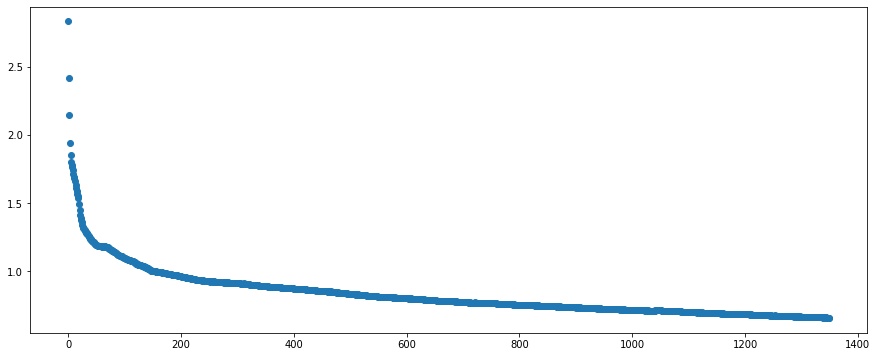

In [ ]:
medium2d = {'LearnBatch':100, 'SecLen':150, 'PredLen':4,
'Epochs':1400, 'LR':0.00195, 'M':0.65, 'SecondDim':4}
trainX2d, trainY2d = BatchGen(train, medium2d['LearnBatch'], medium2d['SecLen'],
                              medium2d['PredLen'], secondDim=medium2d['SecondDim'])

medium2d['cnn'] = MediumCNN2d(LR=medium2d['LR'], m=medium2d['M'],\
                        SecLen=medium2d['SecLen'], PredLen=medium2d['PredLen'])
start_time = datetime.now()
medium2d['losses'] = medium2d['cnn'].fit(trainX2d, trainY2d, epochs=medium2d['Epochs'])

path = '/content/drive/My Drive/Colab Notebooks/ML/dissertation5/medium2dCNN'
torch.save(medium2d, path)

print(datetime.now() - start_time)
plt.figure(figsize=(15, 6))
plt.scatter(np.array([float(i) for i in range(len(medium2d['losses'][50:]))]),\
            medium2d['losses'][50:].numpy())

MAPE [2.9987593266638144, 2.949696569308831, 2.961810782879443, 3.03176470633318]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 1400, 'LR': 0.00195, 'M': 0.65, 'target': 'low'}


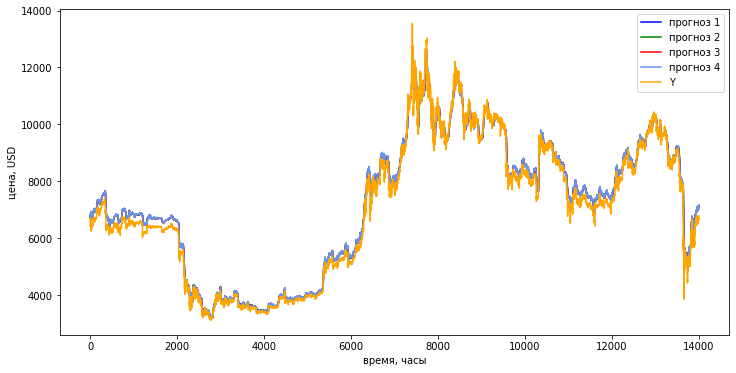

In [ ]:
trainPred = torch.transpose(medium2d['cnn'](TestSample(train, medium2d['SecLen'],\
      secondDim=medium2d['SecondDim'])).view((-1, medium2d['PredLen'])), 0, 1)\
      .detach().numpy() * NormDiv[TargetIndex] + NormSub[TargetIndex]
trainY = data[TargetAttribute][TrainBegin + medium2d['SecLen']:TestBegin].to_numpy()
medium2d['MAPETrain'] = PredMAPE(trainY, trainPred, medium2d['PredLen'])

PlotPredictions(trainY, trainPred, medium2d, medium2d['MAPETrain'])

MAPE [4.749920299576769, 4.641025333049644, 4.718921313695742, 4.851845852865098]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 1400, 'LR': 0.00195, 'M': 0.65, 'target': 'low'}


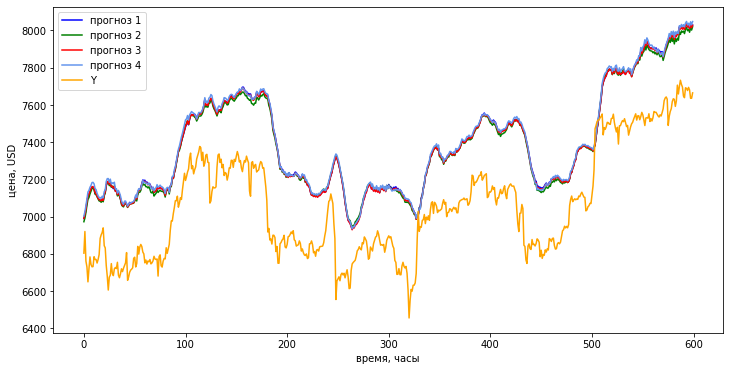

In [28]:
testPred = torch.transpose(medium2d['cnn'](TestSample(test, medium2d['SecLen'],\
      secondDim=medium2d['SecondDim'])).view((-1, medium2d['PredLen'])), 0, 1)\
      .detach().numpy() * NormDiv[TargetIndex] + NormSub[TargetIndex]
testY = data[TargetAttribute][TestBegin + medium2d['SecLen']:ValidBegin].to_numpy()
medium2d['MAPETest'] = PredMAPE(testY, testPred, medium2d['PredLen'])

PlotPredictions(testY, testPred, medium2d, medium2d['MAPETest'])

MAPE [1.8855235889947994, 1.8035999785701744, 1.825465838936531, 1.8688386169003253]
{'SecLen': 150, ' PredLen': 4, 'Epochs': 1400, 'LR': 0.00195, 'M': 0.65, 'target': 'low'}


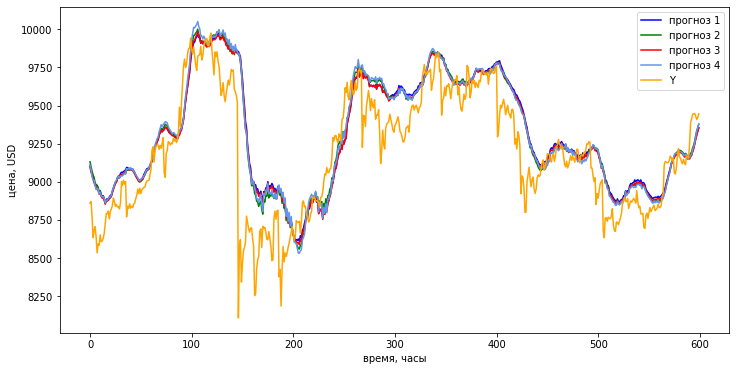

In [27]:
validPred = torch.transpose(medium2d['cnn'](TestSample(valid, medium2d['SecLen'],\
      secondDim=medium2d['SecondDim'])).view((-1, medium2d['PredLen'])), 0, 1)\
      .detach().numpy() * NormDiv[TargetIndex] + NormSub[TargetIndex]
validY = data[TargetAttribute][ValidBegin + medium2d['SecLen']:].to_numpy()
medium2d['MAPEValid'] = PredMAPE(validY, validPred, medium2d['PredLen'])

PlotPredictions(validY, validPred, medium2d, medium2d['MAPETest'])

# Comparison

In [35]:
models = [small, small2d, medium, medium2d]
errors = np.array([model['MAPETest'] for model in models])
bestIndex = np.mean(errors, axis=1).argmin()
print(errors)
print('Best model is ' + str(type(models[bestIndex]['cnn'])) + ' with MAPE ' + str(errors[bestIndex]))

[[2.98435262 2.82400081 2.80124744 3.02788296]
 [1.38114669 1.48468632 1.22229858 1.56750973]
 [1.18953617 1.18240067 1.24368956 1.22701611]
 [4.7499203  4.64102533 4.71892131 4.85184585]]
Best model is <class '__main__.MediumCNN'> with MAPE [1.18953617 1.18240067 1.24368956 1.22701611]
